In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 적용사항
- 타겟 0인거 나는 드롭할거야 ( 이거 보류)
- wma10으로 타겟값 채우기
- 롤링한거(넣지말자)
- train 90%로 하자

In [16]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# font_path = "C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
from sklearn.manifold import TSNE
import re
import talib as tb

In [165]:
def weather(주소,name = 'train'):
    t=0
    if name =='test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        globals()[f'{name}_weather_'+str(i)]=pd.DataFrame()

        for k in range(0,3):
            try:
                weather = pd.read_csv(주소+f'/weather_{i}_{t}.csv')
                if len(weather)==0:
                    weather = pd.read_csv(주소+f'/weather_0_0.csv')
                    weather=weather.set_index('datadate')
                    weather[weather.columns] = 0
                    weather=weather.reset_index()
                weather = weather.set_index('datadate')
                weather['습도(%)']=weather['습도(%)'].apply(lambda x : np.nan if x==' ' else x)
                weather['습도(%)']=weather['습도(%)'].astype('float')
                weather.columns = weather.columns+f'_{k%3}'
                globals()[f'{name}_weather_'+str(i)]=pd.merge(globals()[f'{name}_weather_'+str(i)],weather,how='right',left_index=True, right_index=True)    


            except:
                break
            t+=1



        globals()[f'{name}_weather_'+str(i)]=globals()[f'{name}_weather_'+str(i)].reset_index()
        cols = globals()[f'{name}_weather_'+str(i)].columns
        globals()[f'{name}_weather_'+str(i)]['월일']=globals()[f'{name}_weather_'+str(i)]['datadate']%10000
       

        
        if name == 'train':
            qwe =  globals()[f'{name}_weather_'+str(i)].groupby('월일').mean().reset_index()
            qwe.columns = qwe.columns+'_평균'
            globals()[f'train_weather_평균_'+str(i)]= qwe



            


        globals()[f'{name}_weather_'+str(i)] = pd.merge(globals()[f'{name}_weather_'+str(i)],globals()[f'train_weather_평균_'+str(i)],how='left',left_on = '월일',right_on='월일_평균')
        for c in cols:
            globals()[f'{name}_weather_'+str(i)][c]=globals()[f'{name}_weather_'+str(i)].apply(lambda x: x[c] if np.isnan(x[c]) == False else (0 if np.isnan(x[c+'_평균']) else x[c+'_평균']),axis=1)
                
    
        
        
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        else:
            globals()[f'{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        

In [166]:
def add_dosomae(주소,name='train', option=1):
        if name == 'test':
            test_dir = 주소.split('/')[-2][-1]
        data_list = glob(주소+'*') # train raw 데이터 넣을지 / test raw 데이터 넣을지 경로
        domae = []
        somae = []

        for i in data_list:
            if 'domae' in i:
                domae.append(i)
            if 'somae' in i:
                somae.append(i)
        
        sum_df = pd.DataFrame()
                
        if option == 1:
            df = domae
            text = 'domae'
        else:
            df = somae
            text = 'somae'


        for i in tqdm(df):
            test = pd.read_csv(i)
            
            k=i.split('/')[-1].split("_")[1].split(".")[0]
            test.fillna(0,inplace=True) # 널값 0으로 채워주고
            if len(test)==0:
                test = pd.read_csv(주소+f'/domae_0.csv')
                test=test.set_index('datadate')
                test[test.columns] = 0
                test=test.reset_index()
                

            
            test['조사단위(kg)'] = test['조사단위(kg)'].replace('g$|kg$|개|포기|접', '',regex=True)
            test=test.astype({'조사단위(kg)':'float'})
            test.loc[test['조사단위(kg)'] >= 100, '단위당가격'] = test['가격(원)']* test['조사단위(kg)'] /1000
            test.loc[test['조사단위(kg)'] < 100, '단위당가격'] = test['가격(원)']/ test['조사단위(kg)']
            
            sep = test.loc[(test['등급명'] == '상품') | (test['등급명'] == 'S과') | (test['등급명'] == 0)]   # 모든 상품에 대해서 수행하지 않고 GRAD_NM이 '상품', 'S과' 만 해당하는 품목 가져옴
            sep = sep[['datadate', '등급명', '조사단위(kg)', '가격(원)']]

            sep.rename(columns={"가격(원)": "가격"}, inplace=True)
            sep2 = sqldf(
                f"select datadate, max(가격) as '일자별_{text}가격_최대(원)', avg(가격) as '일자별_{text}가격_평균(원)', min(가격) as '일자별_{text}가격_최소(원)' from sep group by datadate")

            sep2.fillna(0,inplace=True)
#             if len(sep2) == 0:
#                 if name=='test':
#                     sep2 =  globals()['sep_'+test_dir+f'_{name}_{text}_0'] 
#                     sep2

#                 else:
#                     sep2 =  globals()[f'{name}_{text}_0'] 
#                     sep2[sep2.columns] = 0 
                
                
            if name=='test':
                globals()['sep_'+test_dir+f'_{name}_{text}_{k}'] = sep2
                
            else:
                globals()[f'{name}_{text}_{k}'] = sep2
 
                


        
                               
               
             

In [167]:
def pummok(주소,name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):

        try:
            pummok = pd.read_csv(주소+f'/pummok_{i}.csv')
            if len(pummok) == 0 :
                pummok = pd.read_csv(주소+f'/pummok_0.csv')
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]
                pummok[pummok.columns] = 0
                pummok = pummok.reset_index()
                
            else:   
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]

                # 새로 추가한 부분
                pummok['해당일자_전체평균가격(원)'].fillna(0, inplace=True)
                pummok['wma10'] =  tb.WMA(pummok['해당일자_전체평균가격(원)'], 10)
                pummok['wma10'].fillna(method='bfill', inplace=True)
                pummok['해당일자_전체평균가격(원)'] = np.where(pummok['해당일자_전체평균가격(원)']==0, pummok['wma10'], pummok['해당일자_전체평균가격(원)'])
                pummok.drop('wma10', axis=1, inplace=True)


                
                pummok = pummok.reset_index()
                pummok.fillna(0, inplace = True)
                # pummok.fillna(0,inplace = True)
                
                
                

        except:
            continue

        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_pummok_{i}'] = pummok

        else:
            globals()[f'{name}_pummok_{i}'] = pummok


In [168]:
def imexport(주소, name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        try:
            imexport=pd.read_csv(주소+f'/imexport_{i}.csv')
            
            if len(imexport) == 0:
                imexport = pd.read_csv(주소+f'/imexport_0.csv')
                imexport = imexport.groupby('datadate').mean()
                imexport[imexport.columns] = 0

            else:  
                imexport = imexport.groupby('datadate').mean()


        except:
            
            imexport = pd.read_csv(주소+f'/imexport_0.csv')
            imexport = imexport.groupby('datadate').mean()
            imexport[imexport.columns] = 0
            pass


        imexport.fillna(0,inplace=True)
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_imexport_{i}'] = imexport

        else:
            globals()[f'{name}_imexport_{i}'] = imexport


    
    

In [169]:
def make_csv(주소,name = 'train'):
    imexport(주소,name)
    pummok(주소,name)
    add_dosomae(주소,name)
    add_dosomae(주소,name,2)
    weather(주소,name)
    for i in range(0,37):
        if name == 'test':

            num = 주소.split('/')[-2][-1]
            
            
            temp = globals()[f'sep_{num}_{name}_pummok_{i}']

            temp1 = globals()[f'sep_{num}_{name}_weather_{i}']

            temp2 = globals()[f'sep_{num}_{name}_domae_{i}']
   
            temp3 = globals()[f'sep_{num}_{name}_somae_{i}']

            temp4 = globals()[f'sep_{num}_{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)

            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)


            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_sep_{num}_{i}'] = temp


        else:
            temp = globals()[f'{name}_pummok_{i}']
            temp1 = globals()[f'{name}_weather_{i}']
            temp2 = globals()[f'{name}_domae_{i}']
            temp3 = globals()[f'{name}_somae_{i}']
            temp4 = globals()[f'{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)
            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)


            # 내가 추가한 코드 - 넌값 처리하기 위해(소매에서 넌값이 나온다)
            temp.fillna(0, inplace=True)

            globals()[f'{name}_total_{i}'] = temp
        
    

In [112]:
# train_data만들기 train_total_0 ~ train_total_36까지 만들어준다.
make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_train_raw/','train')

100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


In [170]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    # 변동률 변수 만들어주기
    globals()[f'test_total_sep_{i}_{j}'] = make_change_rate(globals()[f'test_total_sep_{i}_{j}'])
    print(globals()[f'test_total_sep_{i}_{j}'].isna().sum().sum())

100%|██████████| 37/37 [00:00<00:00, 255.72it/s]

100%|██████████| 37/37 [00:00<00:00, 111.52it/s]

100%|██████████| 37/37 [00:01<00:00, 18.89it/s]

100%|██████████| 37/37 [00:02<00:00, 18.14it/s]

100%|██████████| 37/37 [00:01<00:00, 32.09it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 10%|█         | 1/10 [00:06<00:56,  6.31s/it]

0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 268.44it/s]

100%|██████████| 37/37 [00:00<00:00, 107.92it/s]

100%|██████████| 37/37 [00:01<00:00, 18.95it/s]

100%|██████████| 37/37 [00:02<00:00, 18.07it/s]

100%|██████████| 37/37 [00:01<00:00, 32.69it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 20%|██        | 2/10 [00:12<00:50,  6.29s/it]

0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 265.32it/s]

100%|██████████| 37/37 [00:00<00:00, 110.15it/s]

100%|██████████| 37/37 [00:01<00:00, 18.98it/s]

100%|██████████| 37/37 [00:02<00:00, 18.12it/s]

100%|██████████| 37/37 [00:01<00:00, 33.05it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 30%|███       | 3/10 [00:18<00:43,  6.27s/it]

0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 256.91it/s]

100%|██████████| 37/37 [00:00<00:00, 101.02it/s]

100%|██████████| 37/37 [00:01<00:00, 18.76it/s]

100%|██████████| 37/37 [00:02<00:00, 14.88it/s]

100%|██████████| 37/37 [00:01<00:00, 25.35it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 40%|████      | 4/10 [00:25<00:39,  6.60s/it]

0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 258.17it/s]

100%|██████████| 37/37 [00:00<00:00, 93.94it/s]

100%|██████████| 37/37 [00:02<00:00, 18.47it/s]

100%|██████████| 37/37 [00:02<00:00, 17.86it/s]

100%|██████████| 37/37 [00:01<00:00, 32.94it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 50%|█████     | 5/10 [00:32<00:32,  6.53s/it]

0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 268.49it/s]

100%|██████████| 37/37 [00:00<00:00, 100.51it/s]

100%|██████████| 37/37 [00:01<00:00, 18.81it/s]

100%|██████████| 37/37 [00:02<00:00, 17.75it/s]

100%|██████████| 37/37 [00:01<00:00, 32.92it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 60%|██████    | 6/10 [00:38<00:25,  6.48s/it]

0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 262.53it/s]

100%|██████████| 37/37 [00:00<00:00, 106.76it/s]

100%|██████████| 37/37 [00:01<00:00, 19.05it/s]

100%|██████████| 37/37 [00:02<00:00, 18.22it/s]

100%|██████████| 37/37 [00:01<00:00, 33.19it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 70%|███████   | 7/10 [00:44<00:19,  6.40s/it]

0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 263.15it/s]

100%|██████████| 37/37 [00:00<00:00, 121.83it/s]

100%|██████████| 37/37 [00:01<00:00, 19.12it/s]

100%|██████████| 37/37 [00:01<00:00, 18.54it/s]

100%|██████████| 37/37 [00:01<00:00, 32.75it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 80%|████████  | 8/10 [00:51<00:12,  6.34s/it]

0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 250.60it/s]

100%|██████████| 37/37 [00:00<00:00, 106.71it/s]

100%|██████████| 37/37 [00:02<00:00, 17.63it/s]

100%|██████████| 37/37 [00:02<00:00, 16.05it/s]

100%|██████████| 37/37 [00:01<00:00, 33.01it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 90%|█████████ | 9/10 [00:57<00:06,  6.46s/it]

0
0
0
0
0
0
0
0
0
0
0
0



100%|██████████| 37/37 [00:00<00:00, 273.12it/s]

100%|██████████| 37/37 [00:00<00:00, 102.65it/s]

100%|██████████| 37/37 [00:01<00:00, 18.71it/s]

100%|██████████| 37/37 [00:02<00:00, 14.98it/s]

100%|██████████| 37/37 [00:01<00:00, 32.51it/s]


0
0
0
0
0
0
0
84
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


100%|██████████| 10/10 [01:04<00:00,  6.47s/it]

0
0
0
0
0
0
0
0
0
0
0


## 변동률 파생변수 만들기

In [113]:
# 변동률 넣어주는 코드
def make_change_rate(df):
  df['1일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=1)
  df['1일변동률'].fillna(method = 'bfill', inplace=True)
  df['3일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=3)
  df['3일변동률'].fillna(method = 'bfill', inplace=True)
  df['5일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=5)
  df['5일변동률'].fillna(method = 'bfill', inplace=True)
  df['7일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=7)
  df['7일변동률'].fillna(method = 'bfill', inplace=True)
  df['10일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=10)
  df['10일변동률'].fillna(method = 'bfill', inplace=True)
  df['13일변동률'] = df['해당일자_전체평균가격(원)'].pct_change(periods=13)
  df['13일변동률'].fillna(method = 'bfill', inplace=True)

  #
  return df

In [114]:
# train 데이터 변동률 변수 추가 
for i in range(37):
  globals()[f'train_total_{i}'] = make_change_rate(globals()[f'train_total_{i}'])

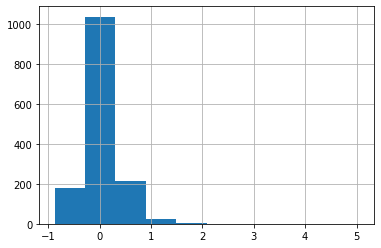

In [173]:
train_total_36['13일변동률'].hist()

In [116]:

make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/','test')

단가(원)                0
거래량                  0
해당일자_전체평균가격(원)       0
초기온도(℃)_0            0
최대온도(℃)_0            0
최저온도(℃)_0            0
평균온도(℃)_0            0
강수량(ml)_0            0
습도(%)_0              0
초기온도(℃)_1            0
최대온도(℃)_1            0
최저온도(℃)_1            0
평균온도(℃)_1            0
강수량(ml)_1            0
습도(%)_1              0
초기온도(℃)_2            0
최대온도(℃)_2            0
최저온도(℃)_2            0
평균온도(℃)_2            0
강수량(ml)_2            0
습도(%)_2              0
일자별_domae가격_최대(원)    0
일자별_domae가격_평균(원)    0
일자별_domae가격_최소(원)    0
일자별_somae가격_최대(원)    0
일자별_somae가격_평균(원)    0
일자별_somae가격_최소(원)    0
수출중량(kg)             0
수출금액(달러)             0
수입중량(kg)             0
수입금액(달러)             0
무역수지(달러)             0
1일변동률                0
3일변동률                0
5일변동률                0
7일변동률                0
10일변동률               0
13일변동률               0
dtype: int64

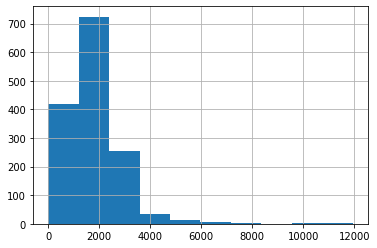

In [177]:
train_total_7['해당일자_전체평균가격(원)'].hist()

In [118]:
for i in range(37):
  print(globals()[f'train_total_{i}'].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


## train 데이터 스케일링

In [119]:
# train 데이터스케일링 하기
def scaling_df(df):
  scaler = StandardScaler()
  
  
  tmp = df.drop(['해당일자_전체평균가격(원)','1일변동률', '3일변동률', '5일변동률', '7일변동률', '10일변동률', '13일변동률'],axis=1).copy()
  # tmp2 = df[['1일변동률', '3일변동률', '5일변동률', '7일변동률', '10일변동률', '13일변동률']]
  scaler.fit(tmp)
  df_scaled = scaler.transform(tmp)
  df_scaled = pd.DataFrame(data=df_scaled, columns = tmp.columns)


  df_scaled['1일변동률'] = df['1일변동률'].values
  df_scaled['3일변동률'] = df['3일변동률'].values
  df_scaled['5일변동률'] = df['5일변동률'].values
  df_scaled['7일변동률'] = df['7일변동률'].values
  df_scaled['10일변동률'] = df['10일변동률'].values
  df_scaled['13일변동률'] = df['13일변동률'].values
  df_scaled['log_target'] = np.log1p(df['해당일자_전체평균가격(원)']).values 
  return df_scaled

In [120]:
# train 데이터 스케일링
for i in range(37):
  globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'train_total_{i}'])

In [121]:
train_scaled_36.isna().sum()

단가(원)                0
거래량                  0
초기온도(℃)_0            0
최대온도(℃)_0            0
최저온도(℃)_0            0
평균온도(℃)_0            0
강수량(ml)_0            0
습도(%)_0              0
초기온도(℃)_1            0
최대온도(℃)_1            0
최저온도(℃)_1            0
평균온도(℃)_1            0
강수량(ml)_1            0
습도(%)_1              0
초기온도(℃)_2            0
최대온도(℃)_2            0
최저온도(℃)_2            0
평균온도(℃)_2            0
강수량(ml)_2            0
습도(%)_2              0
일자별_domae가격_최대(원)    0
일자별_domae가격_평균(원)    0
일자별_domae가격_최소(원)    0
일자별_somae가격_최대(원)    0
일자별_somae가격_평균(원)    0
일자별_somae가격_최소(원)    0
수출중량(kg)             0
수출금액(달러)             0
수입중량(kg)             0
수입금액(달러)             0
무역수지(달러)             0
1일변동률                0
3일변동률                0
5일변동률                0
7일변동률                0
10일변동률               0
13일변동률               0
log_target           0
dtype: int64

## 라쏘 회귀로 feature selection

In [124]:
from sklearn import *
def lasso_feature_selection(df):

    X_train = df.drop(['log_target'], axis=1)
    y_train = df["log_target"]
    
    regressor = linear_model.Lasso(alpha=0.01,
                               positive=True,
                               fit_intercept=False, 
                               max_iter=1000,
                               tol=0.0001)
    regressor.fit(X_train, y_train)
    
    fs = pd.DataFrame(regressor.coef_, index=X_train.columns)
    fs.columns = ['weights']
    sc = list(fs[fs['weights'] > 0].index)
    
    

    df = df[sc]
    df['log_target'] = y_train
    #print(f'품목의 selected_feature: {sc}')
    return df


In [125]:
# train 데이터 라쏘회귀로 feature selection
for i in range(37):
  globals()[f'final_train_{i}'] = lasso_feature_selection(globals()[f'train_scaled_{i}'])
  print(globals()[f'final_train_{i}'].columns)
  

Index(['거래량', '초기온도(℃)_0', '최저온도(℃)_0', '강수량(ml)_0', '습도(%)_1', '습도(%)_2',
       '일자별_somae가격_최대(원)', '수출중량(kg)', '수입중량(kg)', '무역수지(달러)', '1일변동률',
       '3일변동률', '5일변동률', '7일변동률', '10일변동률', '13일변동률', 'log_target'],
      dtype='object')
Index(['최대온도(℃)_0', '일자별_domae가격_최소(원)', '수입중량(kg)', '1일변동률', '3일변동률', '5일변동률',
       '7일변동률', '10일변동률', '13일변동률', 'log_target'],
      dtype='object')
Index(['초기온도(℃)_0', '평균온도(℃)_0', '강수량(ml)_0', '최대온도(℃)_1', '강수량(ml)_1',
       '수출금액(달러)', '수입중량(kg)', '1일변동률', '3일변동률', '5일변동률', '7일변동률', '10일변동률',
       '13일변동률', 'log_target'],
      dtype='object')
Index(['최저온도(℃)_1', '평균온도(℃)_1', '습도(%)_1', '수출금액(달러)', '1일변동률', '3일변동률',
       '5일변동률', '7일변동률', '10일변동률', '13일변동률', 'log_target'],
      dtype='object')
Index(['초기온도(℃)_0', '최저온도(℃)_0', '최대온도(℃)_2', '습도(%)_2', '수입중량(kg)',
       '수입금액(달러)', '1일변동률', '3일변동률', '5일변동률', '7일변동률', '10일변동률', '13일변동률',
       'log_target'],
      dtype='object')
Index(['강수량(ml)_0', '습도(%)_0', '평균온도(℃)_1', '강수량(ml)_1', '최대온

# 모델링

In [55]:
try_cnt = 10 # 모델이나 체크포인트를 각자 다른 폴더에 저장해주기 위해
            # 새로운거 시도할때마다 숫자 바꿔서 내면된다.

In [127]:
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [128]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [129]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(28)(x) # 4주 예측
    return keras.Model(inputs, outputs)

In [130]:
def call_back_set(name, epoch, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=100)

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}') == False:
        os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}')

    filename = f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/{name}-{epoch}-{batch_size}.h5'

    checkpoint = ModelCheckpoint(filename,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto'
                                 )
    return [early_stopping, checkpoint]

In [131]:
def train(x_train, y_train, x_val, y_val, name, epoch, batch_size, learning_rate = 0.001, verbose = 1):


    model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )


    # Train the model
    with tf.device('/device:GPU:0'):
        history1 = model.fit(
            x_train, y_train,
            epochs = epoch,
            steps_per_epoch=len(x_train) / batch_size,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            validation_steps=len(x_val) / batch_size,
            shuffle=False,
            callbacks=call_back_set(name, epoch, batch_size),
            verbose=verbose)

    return model

In [132]:
def time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in tqdm(range(len(df) - seqence_length)):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

In [133]:
epoch = 1000
batch = 15

In [145]:
final_train_6.describe()

,단가(원),거래량,최대온도(℃)_0,강수량(ml)_1,최대온도(℃)_2,수입금액(달러),1일변동률,3일변동률,5일변동률,7일변동률,10일변동률,13일변동률,log_target
count,1461.000000,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03
mean,0.000000,1.264484e-16,1.945360e-17,-1.459020e-17,1.459020e-17,-7.781440e-17,1.575805e+12,3.803757e+11,2.936729e+11,1.250796e+12,2.000959e+12,1.917285e+12,7.869862e+00
std,1.000342,1.000342e+00,1.000342e+00,1.000342e+00,1.000342e+00,1.000342e+00,6.286905e+13,1.432579e+13,1.097714e+13,4.627052e+13,6.547727e+13,5.965895e+13,1.103747e+00
min,-0.041034,-7.168166e-01,-2.733623e+00,-3.563736e-01,-2.518954e+00,-1.586696e+00,-7.626762e+13,-7.649169e+13,-7.839473e+13,-7.862505e+13,-5.305268e+13,-5.717017e+13,-5.249934e-10
25%,-0.041034,-7.168166e-01,-8.458496e-01,-3.563736e-01,-8.261700e-01,-7.791242e-01,-2.226479e-01,-2.689284e-01,-2.939553e-01,-2.829876e-01,-3.559840e-01,-3.696952e-01,7.540834e+00
50%,-0.030626,-5.735984e-01,1.217527e-01,-3.563736e-01,7.734030e-02,-2.456452e-01,-3.432321e-02,-4.987080e-02,-5.289759e-02,-3.345725e-02,-5.541828e-02,-6.949091e-02,7.910064e+00
75%,-0.025685,6.740051e-01,8.616839e-01,-1.627144e-01,8.769988e-01,8.628571e-01,1.451783e-01,2.286607e-01,2.544317e-01,2.208587e-01,3.328859e-01,3.588570e-01,8.266776e+00
max,38.199637,1.023937e+01,1.971581e+00,1.103079e+01,1.946672e+00,2.372119e+00,2.401704e+15,4.065580e+14,3.162118e+14,1.751539e+15,2.416507e+15,2.098499e+15,1.102510e+01


In [164]:
#for i in range(37):
for i in range(17, 37):

    df_number = i
    df = globals()[f'final_train_{i}']
    
    # nan 처리
    df.fillna(0, inplace = True)
    
  

    

    # 변수와 타겟 분리
    x, y = df[[i for i in df.columns if i != 'log_target']], df['log_target']

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # time series window 생성
    data_x = time_window(x, 13, 1)
    data_y = time_window(y, 27, 1)

    # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    # train, validation 분리 (9 : 1)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.1, shuffle=False, random_state=119)

    # transformer 모델 훈련
    transformer = train(astype_data(x_train), y_train, astype_data(x_val), y_val, f'transformer-{df_number}', epoch, batch)
    transformer.load_weights(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

# keras.models.load_model

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}') == False:
         os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}')

    
    
    
    # 모델 저장
    transformer.save(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

100%|██████████| 1419/1419 [00:00<00:00, 35317.15it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 16.6862
Epoch 1: val_loss improved from inf to 1.16278, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-17-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 16.6862 - val_loss: 1.1628
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 2.9096
Epoch 2: val_loss improved from 1.16278 to 0.20680, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-17-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.9096 - val_loss: 0.2068
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.1632
Epoch 3: val_loss did not improve from 0.20680
85/85 [==============================] - 1s 11ms/step - loss: 2.1632 - val_loss: 1.5487
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 1.8226
Epoch 4: val_loss did not improve from 0.20680
85/85 [==============================] - 1s 11ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 34788.89it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 30.4023
Epoch 1: val_loss improved from inf to 7.43525, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-18-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 30.4023 - val_loss: 7.4353
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 11.1973
Epoch 2: val_loss improved from 7.43525 to 1.65088, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-18-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 11.1973 - val_loss: 1.6509
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 11.2399
Epoch 3: val_loss did not improve from 1.65088
85/85 [==============================] - 1s 11ms/step - loss: 11.2399 - val_loss: 1.8935
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 6.1879
Epoch 4: val_loss improved from 1.65088 to 1.02347, saving model to /content/drive/MyDrive/농산물예측/aT_d

100%|██████████| 1419/1419 [00:00<00:00, 34774.66it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 14.2918
Epoch 1: val_loss improved from inf to 1.12143, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-19-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 14.2918 - val_loss: 1.1214
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.0774
Epoch 2: val_loss improved from 1.12143 to 0.49575, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-19-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 3.0774 - val_loss: 0.4957
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.4557
Epoch 3: val_loss improved from 0.49575 to 0.28844, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-19-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.4557 - val_loss: 0.2884
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 1.9800
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 35014.43it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.0547
Epoch 1: val_loss improved from inf to 0.18689, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-20-1000-15.h5
85/85 [==============================] - 4s 16ms/step - loss: 15.0547 - val_loss: 0.1869
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.2981
Epoch 2: val_loss did not improve from 0.18689
85/85 [==============================] - 1s 11ms/step - loss: 3.2981 - val_loss: 0.9594
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.8301
Epoch 3: val_loss improved from 0.18689 to 0.15182, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-20-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.8301 - val_loss: 0.1518
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.1366
Epoch 4: val_loss did not improve from 0.15182
85/85 [==============================] - 1s 11ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 35809.07it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 13.8847
Epoch 1: val_loss improved from inf to 3.64685, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-21-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 13.8847 - val_loss: 3.6469
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.5108
Epoch 2: val_loss did not improve from 3.64685
85/85 [==============================] - 1s 11ms/step - loss: 3.5108 - val_loss: 8.4161
Epoch 3/1000
85/85 [============================>.] - ETA: 0s - loss: 2.7337
Epoch 3: val_loss did not improve from 3.64685
85/85 [==============================] - 1s 11ms/step - loss: 2.7320 - val_loss: 3.9160
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.1185
Epoch 4: val_loss improved from 3.64685 to 1.87343, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-21-1000-15.h5
85/85 [==============================] - 1s 13ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 34714.21it/s]


Epoch 1/1000
85/85 [============================>.] - ETA: 0s - loss: 11.1722
Epoch 1: val_loss improved from inf to 0.29828, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-22-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 11.1597 - val_loss: 0.2983
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 2.4776
Epoch 2: val_loss did not improve from 0.29828
85/85 [==============================] - 1s 11ms/step - loss: 2.4776 - val_loss: 2.5249
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.0296
Epoch 3: val_loss did not improve from 0.29828
85/85 [==============================] - 1s 11ms/step - loss: 2.0296 - val_loss: 1.6990
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 1.5487
Epoch 4: val_loss did not improve from 0.29828
85/85 [==============================] - 1s 11ms/step - loss: 1.5487 - val_loss: 0.5677
Epoch 5/1000
86/85 [==============================] - ETA: 0s 

100%|██████████| 1419/1419 [00:00<00:00, 33910.99it/s]


Epoch 1/1000
85/85 [============================>.] - ETA: 0s - loss: 17.9828
Epoch 1: val_loss improved from inf to 5.85572, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-23-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 17.9806 - val_loss: 5.8557
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 5.4851
Epoch 2: val_loss improved from 5.85572 to 2.95955, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-23-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 5.4851 - val_loss: 2.9595
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 3.5080
Epoch 3: val_loss improved from 2.95955 to 1.69596, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-23-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 3.5080 - val_loss: 1.6960
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.9165
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 32478.14it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.9729
Epoch 1: val_loss improved from inf to 1.14007, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-24-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 15.9729 - val_loss: 1.1401
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 4.6264
Epoch 2: val_loss improved from 1.14007 to 0.32597, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-24-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 4.6264 - val_loss: 0.3260
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.4168
Epoch 3: val_loss improved from 0.32597 to 0.17740, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-24-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 2.4168 - val_loss: 0.1774
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.0596
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 34977.80it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.8074
Epoch 1: val_loss improved from inf to 5.24421, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-25-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 15.8074 - val_loss: 5.2442
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 4.5263
Epoch 2: val_loss improved from 5.24421 to 2.21474, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-25-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 4.5263 - val_loss: 2.2147
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.9407
Epoch 3: val_loss improved from 2.21474 to 0.39193, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-25-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.9407 - val_loss: 0.3919
Epoch 4/1000
85/85 [============================>.] - ETA: 0s - loss: 2.3212
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 30746.31it/s]


Epoch 1/1000
85/85 [============================>.] - ETA: 0s - loss: 15.8802
Epoch 1: val_loss improved from inf to 2.85522, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-26-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 15.8629 - val_loss: 2.8552
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 4.8408
Epoch 2: val_loss improved from 2.85522 to 2.24570, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-26-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 4.8408 - val_loss: 2.2457
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 4.0544
Epoch 3: val_loss did not improve from 2.24570
85/85 [==============================] - 1s 11ms/step - loss: 4.0544 - val_loss: 2.7129
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 3.1135
Epoch 4: val_loss improved from 2.24570 to 2.05737, saving model to /content/drive/MyDrive/농산물예측/aT_data/

100%|██████████| 1419/1419 [00:00<00:00, 33592.31it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.9106
Epoch 1: val_loss improved from inf to 1.75868, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-27-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 15.9106 - val_loss: 1.7587
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.7538
Epoch 2: val_loss improved from 1.75868 to 1.69166, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-27-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 3.7538 - val_loss: 1.6917
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.8501
Epoch 3: val_loss improved from 1.69166 to 0.87054, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-27-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.8501 - val_loss: 0.8705
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.3117
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 31790.98it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 16.5312
Epoch 1: val_loss improved from inf to 0.67877, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-28-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 16.5312 - val_loss: 0.6788
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 7.5925
Epoch 2: val_loss did not improve from 0.67877
85/85 [==============================] - 1s 11ms/step - loss: 7.5925 - val_loss: 2.4926
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 5.7880
Epoch 3: val_loss did not improve from 0.67877
85/85 [==============================] - 1s 11ms/step - loss: 5.7880 - val_loss: 1.2066
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 4.1271
Epoch 4: val_loss did not improve from 0.67877
85/85 [==============================] - 1s 11ms/step - loss: 4.1271 - val_loss: 0.7244
Epoch 5/1000
85/85 [============================>.] - ETA: 0s 

100%|██████████| 1419/1419 [00:00<00:00, 33074.84it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 17.6218
Epoch 1: val_loss improved from inf to 1.86527, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-29-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 17.6218 - val_loss: 1.8653
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 4.6858
Epoch 2: val_loss improved from 1.86527 to 1.60358, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-29-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 4.6858 - val_loss: 1.6036
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.4659
Epoch 3: val_loss improved from 1.60358 to 0.93415, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-29-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.4659 - val_loss: 0.9342
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.0890
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 31159.85it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 16.4584
Epoch 1: val_loss improved from inf to 5.03408, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-30-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 16.4584 - val_loss: 5.0341
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 5.3570
Epoch 2: val_loss improved from 5.03408 to 0.32968, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-30-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 5.3570 - val_loss: 0.3297
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.7348
Epoch 3: val_loss did not improve from 0.32968
85/85 [==============================] - 1s 11ms/step - loss: 2.7348 - val_loss: 0.4551
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.3426
Epoch 4: val_loss did not improve from 0.32968
85/85 [==============================] - 1s 12ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 32818.23it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.6815
Epoch 1: val_loss improved from inf to 2.56327, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-31-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 15.6815 - val_loss: 2.5633
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.1679
Epoch 2: val_loss improved from 2.56327 to 0.88550, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-31-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 3.1679 - val_loss: 0.8855
Epoch 3/1000
84/85 [============================>.] - ETA: 0s - loss: 2.5885
Epoch 3: val_loss did not improve from 0.88550
85/85 [==============================] - 1s 12ms/step - loss: 2.5769 - val_loss: 1.0883
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 1.9904
Epoch 4: val_loss did not improve from 0.88550
85/85 [==============================] - 1s 11ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 30871.34it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 20.1876
Epoch 1: val_loss improved from inf to 2.14830, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-32-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 20.1876 - val_loss: 2.1483
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.7836
Epoch 2: val_loss improved from 2.14830 to 0.79824, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-32-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 3.7836 - val_loss: 0.7982
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.7166
Epoch 3: val_loss improved from 0.79824 to 0.50049, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-32-1000-15.h5
85/85 [==============================] - 1s 12ms/step - loss: 2.7166 - val_loss: 0.5005
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 2.3642
Epoch 4: val_

100%|██████████| 1419/1419 [00:00<00:00, 33092.49it/s]


Epoch 1/1000
85/85 [============================>.] - ETA: 0s - loss: 17.2594
Epoch 1: val_loss improved from inf to 18.67170, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-33-1000-15.h5
85/85 [==============================] - 5s 17ms/step - loss: 17.2413 - val_loss: 18.6717
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 9.9371 
Epoch 2: val_loss improved from 18.67170 to 2.45506, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-33-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 9.9371 - val_loss: 2.4551
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 4.3887
Epoch 3: val_loss did not improve from 2.45506
85/85 [==============================] - 1s 12ms/step - loss: 4.3887 - val_loss: 3.4282
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 4.1397
Epoch 4: val_loss improved from 2.45506 to 2.08210, saving model to /content/drive/MyDrive/농산물예측/aT_d

100%|██████████| 1419/1419 [00:00<00:00, 33438.68it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 20.6948
Epoch 1: val_loss improved from inf to 1.51739, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-34-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 20.6948 - val_loss: 1.5174
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 5.1021
Epoch 2: val_loss did not improve from 1.51739
85/85 [==============================] - 1s 12ms/step - loss: 5.1021 - val_loss: 1.9361
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 4.0933
Epoch 3: val_loss did not improve from 1.51739
85/85 [==============================] - 1s 12ms/step - loss: 4.0933 - val_loss: 3.4560
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 3.2486
Epoch 4: val_loss did not improve from 1.51739
85/85 [==============================] - 1s 12ms/step - loss: 3.2486 - val_loss: 1.6271
Epoch 5/1000
86/85 [==============================] - ETA: 0s 

100%|██████████| 1419/1419 [00:00<00:00, 35163.58it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 18.1679
Epoch 1: val_loss improved from inf to 0.10048, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-35-1000-15.h5
85/85 [==============================] - 4s 17ms/step - loss: 18.1679 - val_loss: 0.1005
Epoch 2/1000
86/85 [==============================] - ETA: 0s - loss: 3.0557
Epoch 2: val_loss did not improve from 0.10048
85/85 [==============================] - 1s 12ms/step - loss: 3.0557 - val_loss: 0.1143
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 2.3155
Epoch 3: val_loss improved from 0.10048 to 0.09450, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-35-1000-15.h5
85/85 [==============================] - 1s 13ms/step - loss: 2.3155 - val_loss: 0.0945
Epoch 4/1000
86/85 [==============================] - ETA: 0s - loss: 1.9332
Epoch 4: val_loss did not improve from 0.09450
85/85 [==============================] - 1s 11ms/step - lo

100%|██████████| 1419/1419 [00:00<00:00, 31104.64it/s]


Epoch 1/1000
86/85 [==============================] - ETA: 0s - loss: 15.7404
Epoch 1: val_loss improved from inf to 0.79179, saving model to /content/drive/MyDrive/농산물예측/aT_data/check10/transformer-36-1000-15.h5
85/85 [==============================] - 5s 24ms/step - loss: 15.7404 - val_loss: 0.7918
Epoch 2/1000
85/85 [============================>.] - ETA: 0s - loss: 4.5527
Epoch 2: val_loss did not improve from 0.79179
85/85 [==============================] - 1s 12ms/step - loss: 4.5507 - val_loss: 1.3527
Epoch 3/1000
86/85 [==============================] - ETA: 0s - loss: 3.1223
Epoch 3: val_loss did not improve from 0.79179
85/85 [==============================] - 1s 12ms/step - loss: 3.1223 - val_loss: 1.2489
Epoch 4/1000
85/85 [============================>.] - ETA: 0s - loss: 2.4911
Epoch 4: val_loss did not improve from 0.79179
85/85 [==============================] - 1s 12ms/step - loss: 2.4893 - val_loss: 0.9566
Epoch 5/1000
86/85 [==============================] - ETA: 0s 

# 답지 만들기

In [175]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    # 변동률 변수 만들어주기
    globals()[f'test_total_sep_{i}_{j}'] = make_change_rate(globals()[f'test_total_sep_{i}_{j}'])

    
    # 스케일링 & 타겟값 변환
    globals()[f'test_total_sep_{i}_{j}'] = scaling_df(globals()[f'test_total_sep_{i}_{j}'])

    # train 데이터랑 똑같이 selection
    globals()[f'test_total_sep_{i}_{j}'] = globals()[f'test_total_sep_{i}_{j}'][list(globals()[f'final_train_{j}'].columns)]

    

    # 해당일자평균가격 테스트 데이터에서는 타겟값 없애고 돌리네
    globals()[f'test_total_sep_{i}_{j}'].drop('log_target',axis=1, inplace=True)


    file_number = j

    # nan 처리
    globals()[f'test_total_sep_{i}_{j}'].fillna(0, inplace = True)
    # 형상 맞추기 코드는 아직 넣지 않았다. (안넣어도 되지 않을까?)

    
    # x_test 생성
    df_test = astype_data(globals()[f'test_total_sep_{i}_{j}'].values.reshape(1, globals()[f'test_total_sep_{i}_{j}'].values.shape[0], globals()[f'test_total_sep_{i}_{j}'].values.shape[1]))



    # model test
    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}')

    # 해당하는 모델 불러오기
   
    model_test = tf.keras.models.load_model(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{file_number}-{epoch}-{batch}.h5')
    pred = model_test.predict(df_test)


    # 여기서 다시 형변환 해주자!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!np.expm1
    pred = np.expm1(pred)

    

    # 결과 저장
    save_df = pd.DataFrame(pred).T
    save_df.to_csv(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}/predict_{file_number}.csv', index=False)


100%|██████████| 37/37 [00:00<00:00, 256.14it/s]

100%|██████████| 37/37 [00:00<00:00, 113.38it/s]

100%|██████████| 37/37 [00:01<00:00, 18.92it/s]

100%|██████████| 37/37 [00:02<00:00, 17.96it/s]

  0%|          | 0/10 [00:35<?, ?it/s]


ValueError: ignored

In [ ]:
# 이부분 세부적으로 다 바꿔야한다.



for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

In [ ]:
set_df_0

In [ ]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

In [ ]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

In [ ]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv(f'/content/drive/MyDrive/농산물예측/submit{try_cnt}.csv',index=False)

In [ ]:
all_df

In [ ]:
out_ans

In [ ]:
submit_df

In [ ]:
# 테스트 데이터 변동률 넣어주기

# 테스트 데이터 스케일링

# 테스트 데이터 feature selection
